# Force curves versus velocity for an $F=1 \rightarrow F'=1$ system
In this notebook, we simulate cooling for an $F=1 \rightarrow F'=1$ system. In particular, we reproduce figures from [NJP 18, 123017 (2016)](https://doi.org/10.1088/1367-2630/18/12/123017).

In [1]:
using Revise

In [6]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

We'll first define a few physical constants needed for this simulation. 

In [7]:
λ = 1; Γ = 2π; m = 1; k = 2π / λ;

Using `QuantumStates`, we can create both the ground states (`F1_lower`) and excited states (`F1_upper`) using the `AngularMomentumState` type, which is a state type of "bare" angular momentum states $|F,m\rangle$.

In [4]:
H_operator = :(
    T * L +
    B_z * (Zeeman_L0 + 2*Zeeman_L1)
)
parameters = @params begin
    T = 1000.
    B_z = 0.
end

# Create basis states
QN_bounds = (L = 0, N = 1)
F1_lower = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
F1_upper = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

ground_states = F1_lower
excited_states = F1_upper
basis = [ground_states; excited_states]

H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(H)
QuantumStates.solve!(H)
;

In [6]:
import QuantumStates.TDM

function TDM(state::AngularMomentumState_Labelled, state′::AngularMomentumState_Labelled, p::Int64)
    L,  N,  M  = unpack(state)
    L′, N′, M′ = unpack(state′)
    if L′ <= L
        return 0.0
    else
        return (
            (-1)^p * (-1)^(N - M) * wigner3j(N, 1, N′, -M, p, M′) * sqrt(2N′ + 1)
        )
    end
end

TDM (generic function with 14 methods)

The transition dipole moments `d` and the magnetic moments `d_m` are calculated using `QuantumStates.get_tdms_two_bases`:

In [7]:
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

# For F=1 -> F=0
# d[1:3, 4, :] .*= sqrt(2*1 + 1) / sqrt(2*0 + 1)
# d[4, 1:3, :] .*= sqrt(2*1 + 1) / sqrt(2*0 + 1)

# For F=2 -> F=1
# d[1:5, 6:8, :] .*= sqrt(2*2 + 1) / sqrt(2*1 + 1)
# d[6:8, 1:5, :] .*= sqrt(2*2 + 1) / sqrt(2*1 + 1)
;

In [8]:
d[:,:,1]

6×6 Matrix{ComplexF64}:
       0.0-0.0im        0.0+0.0im  …  -0.707107+0.0im        0.0+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im  -0.707107+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im        0.0+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im        0.0+0.0im
 -0.707107-0.0im        0.0-0.0im           0.0-0.0im        0.0+0.0im
       0.0-0.0im  -0.707107-0.0im  …        0.0-0.0im        0.0-0.0im

In [9]:
# d_ge = get_tdms_two_bases(ground_states, excited_states, TDM)
# d = zeros(length(H.states), length(H.states), 3)
# d[1:length(ground_states), (length(ground_states)+1):length(H.states), :] .= d_ge
# d[(length(ground_states)+1):length(H.states), 1:length(ground_states), :] .= permutedims(d_ge, (2,1,3))
# ;

We now define the lasers, along with the detuning $\Delta$ and saturation $s$. Note that all lasers have the polarization $\sigma^+$ in their own frame, which is rotated to the $\hat{z}$ axis using `rotate_pol`. (Technically, the rotation is performed _from_ the $\hat{z}$ axis _to_ the axis of the given laser's $k$-vector because the variable $\sigma^+$ is defined relative to the $\hat{z}$ axis.)

In [10]:
ϕ = π/2

lin_xy = cart2sph * [1,0,0]
linϕ_xy = cart2sph * [cos(ϕ), sin(ϕ), 0]

lin_yz = cart2sph * [0,1,0]
linϕ_yz = cart2sph * [0, cos(ϕ), sin(ϕ)]

lin_zx = cart2sph * [0,0,1]
linϕ_zx = cart2sph * [sin(ϕ), 0, cos(ϕ)]
;

In [153]:
# Laser parameters
Δ = -2.5Γ
s = 2.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * H.parameters.T + Δ

ϵ_(ϵ1) = t -> ϵ1
s_func(s) = (r,t) -> s

ϕ = π/2

lin = cart2sph * [1,0,0]
linϕ = cart2sph * [cos(ϕ), sin(ϕ), 0]
lin_z = [0,1,0]

# k̂ = +x̂; ϵ1 = ϵ_(lin_yz); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(linϕ_yz); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(lin_zx); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(linϕ_zx); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(lin_xy); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(linϕ_xy); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_(cart2sph * [0,1,0]); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(cart2sph * [0,0,1]); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(cart2sph * [1,0,0]); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(cart2sph * [0,0,1]); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(cart2sph * lin ); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(cart2sph * linϕ); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# xp_ϵ = cart2sph * [0, -im, -1] / √2
# xm_ϵ = cart2sph * [0, -im, +1] / √2
# yp_ϵ = cart2sph * [-1, 0, -im] / √2
# ym_ϵ = cart2sph * [+1, 0, -im] / √2
# zp_ϵ = cart2sph * [-1, -im, 0] / √2
# zm_ϵ = cart2sph * [+1, -im, 0] / √2

# k̂ = +x̂; ϵ1 = ϵ_(xp_ϵ); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(xm_ϵ); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(yp_ϵ); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(ym_ϵ); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers =  [laser3, laser4]
# lasers =  [laser5, laser6]

# k̂ = +ẑ; ϵ = ϵ_( rotate_pol((σ⁺+σ⁻)/√2, k̂)); laser_ = Field(k̂, ϵ, ω_F1_to_F1, s)
# lasers = [laser_]

# k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(-rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(-rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s_func(s))
k̂ = -x̂; ϵ2 = ϵ_( rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s_func(s))
k̂ = +ŷ; ϵ3 = ϵ_(-rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s_func(s))
k̂ = -ŷ; ϵ4 = ϵ_( rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s_func(s))
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s_func(s))
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s_func(s))

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

Before computing the force across a range of velocities, let's first check that our simulation produces reasonable results for a specific set of parameters:

In [154]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 20p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [155]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  2.030978 seconds (1.72 M allocations: 151.299 MiB, 9.59% gc time, 95.20% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -1.7459415995601566e-6
  2.770950032160867e-16
 -2.7716311686200513e-16

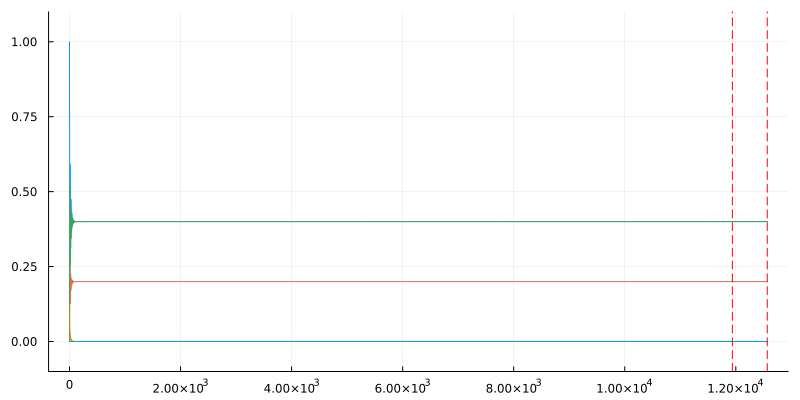

In [156]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

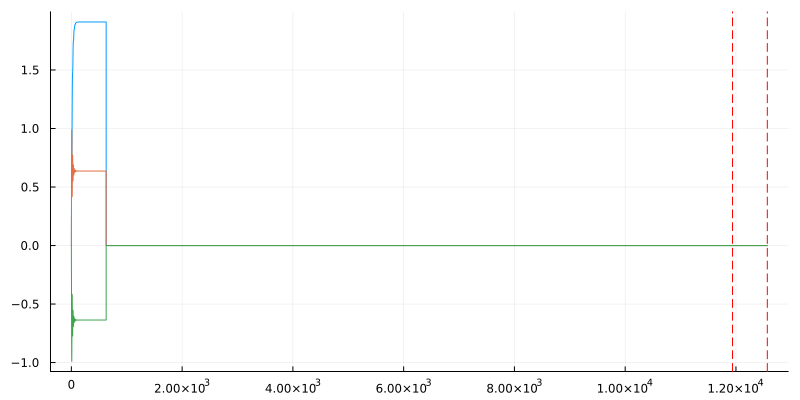

In [157]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [158]:
# E_test(x,y,z) = √2 .* [sin(k * z) - cos(k * y), sin(k * x) - cos(k * z), sin(k * y) - cos(k * x)] .* cos(p.fields.ω[1] * t_end)
E_test(x,y,z) = √2 .* [sin(z) - cos(y), sin(x) - cos(z), sin(y) - cos(x)] .* cos(p.fields.ω[1] * t_end)
# E_test(x,y,z) = √2 .* [sin(z), - cos(z), 0] .* cos(p.fields.ω[1] * t_end)

E_test (generic function with 1 method)

In [159]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus velocity

In [160]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [161]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [162]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

In [163]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


 55.389490 seconds (4.02 M allocations: 1005.704 MiB, 0.16% gc time, 29.73% compilation time)


In [164]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.131877 seconds (74.85 k allocations: 6.563 MiB, 92.71% compilation time)


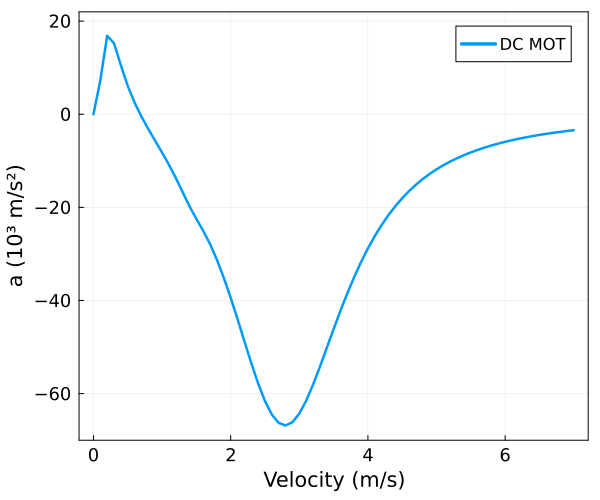

In [165]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [139]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [118]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [59]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


 36.451511 seconds (925.21 k allocations: 265.463 MiB, 2.97% compilation time)


In [60]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.335659 seconds (328.37 k allocations: 63.481 MiB, 26.53% gc time, 27.44% compilation time)


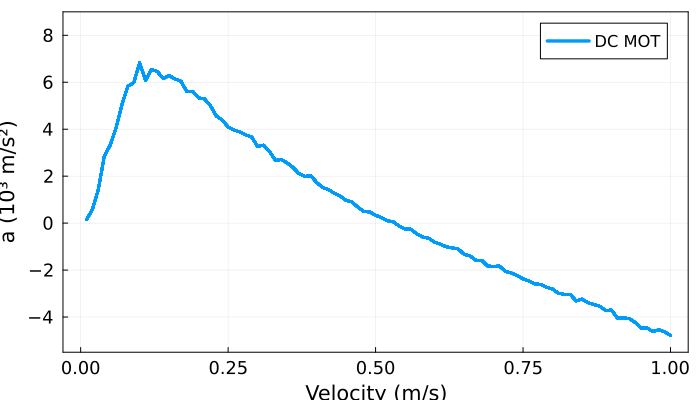

In [61]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [29]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [30]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

Bs = (0:0.2:2.0)
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [31]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: objects of type Float64 are not callable
    Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?
    Stacktrace:
      [1] [0m[1mupdate_fields![22m[0m[1m([22m[90mfields[39m::[0mStructArrays.StructVector[90m{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}[39m, [90mr[39m::[0mStaticArraysCore.MVector[90m{3, Float64}[39m, [90mt[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [35mOpticalBlochEquations[39m [90mC:\Google Drive\github\OpticalBlochEquations\src\[39m[90m[4mfield.jl:52[24m[39m
      [2] [0m[1mupdate_H_obes![22m[0m[1m([22m[90mp[39m::[0mMutableNamedTuples.MutableNamedTuple[90m{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}[39m, [90mτ[39m::[0mFloat64, [90mr[39m::[0mStaticArraysCore.MVector[90m{3, Float64}[39m, [90mH₀[39m::[0mStructArrays.StructArray[90m{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}[39m, [90mfields[39m::[0mStructArrays.StructVector[90m{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}[39m, [90mH[39m::[0mStructArrays.StructArray[90m{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}[39m, [90mE_k[39m::[0mVector[90m{StaticArraysCore.SVector{3, ComplexF64}}[39m, [90mds[39m::[0mVector[90m{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}[39m, [90mds_state1[39m::[0mVector[90m{Vector{Int64}}[39m, [90mds_state2[39m::[0mVector[90m{Vector{Int64}}[39m, [90mJs[39m::[0mVector[90m{OpticalBlochEquations.Jump}[39m[0m[1m)[22m
    [90m    @[39m [35mOpticalBlochEquations[39m [90mC:\Google Drive\github\OpticalBlochEquations\src\[39m[90m[4mHamiltonian.jl:173[24m[39m
      [3] [0m[1mρ![22m[0m[1m([22m[90mdρ[39m::[0mVector[90m{ComplexF64}[39m, [90mρ[39m::[0mVector[90m{ComplexF64}[39m, [90mp[39m::[0mMutableNamedTuples.MutableNamedTuple[90m{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}[39m, [90mτ[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [35mOpticalBlochEquations[39m [90mC:\Google Drive\github\OpticalBlochEquations\src\[39m[90m[4mobe.jl:376[24m[39m
      [4] [0m[1mVoid[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\SciMLBase\QqtZA\src\[39m[90m[4mutils.jl:467[24m[39m[90m [inlined][39m
      [5] [0m[1m(::FunctionWrappers.CallWrapper{Nothing})[22m[0m[1m([22m[90mf[39m::[0mSciMLBase.Void[90m{typeof(ρ!)}[39m, [90marg1[39m::[0mVector[90m{ComplexF64}[39m, [90marg2[39m::[0mVector[90m{ComplexF64}[39m, [90marg3[39m::[0mMutableNamedTuples.MutableNamedTuple[90m{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}[39m, [90marg4[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [36mFunctionWrappers[39m [90mC:\Users\halla\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:65[24m[39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:137[24m[39m[90m [inlined][39m
      [7] [0m[1mdo_ccall[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:125[24m[39m[90m [inlined][39m
      [8] [0m[1mFunctionWrapper[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\FunctionWrappers\Q5cBx\src\[39m[90m[4mFunctionWrappers.jl:144[24m[39m[90m [inlined][39m
      [9] [0m[1m_call[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\FunctionWrappersWrappers\9XR0m\src\[39m[90m[4mFunctionWrappersWrappers.jl:12[24m[39m[90m [inlined][39m
     [10] [0m[1mFunctionWrappersWrapper[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\FunctionWrappersWrappers\9XR0m\src\[39m[90m[4mFunctionWrappersWrappers.jl:10[24m[39m[90m [inlined][39m
     [11] [0m[1mODEFunction[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\SciMLBase\QqtZA\src\[39m[90m[4mscimlfunctions.jl:2096[24m[39m[90m [inlined][39m
     [12] [0m[1minitialize![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{DP5, true, Vector{ComplexF64}, Nothing, Float64, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64, Float64, Float64, Float64, Vector{Vector{ComplexF64}}, ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :save_on, :callback), Tuple{Float64, Bool, DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}}, SciMLBase.StandardODEProblem}, DP5, OrdinaryDiffEq.InterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{ComplexF64}}, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, OrdinaryDiffEq.DP5Cache{Vector{ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, OrdinaryDiffEq.DP5ConstantCache{Float64, Float64}}}, DiffEqBase.DEStats, Nothing}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.DP5Cache{Vector{ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, OrdinaryDiffEq.DP5ConstantCache{Float64, Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(opnorm), Nothing, CallbackSet{Tuple{}, Tuple{DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{ComplexF64}, ComplexF64, Nothing, OrdinaryDiffEq.DefaultInit}[39m, [90mcache[39m::[0mOrdinaryDiffEq.DP5Cache[90m{Vector{ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, OrdinaryDiffEq.DP5ConstantCache{Float64, Float64}}[39m[0m[1m)[22m
    [90m    @[39m [32mOrdinaryDiffEq[39m [90mC:\Users\halla\.julia\packages\OrdinaryDiffEq\P7HJO\src\perform_step\[39m[90m[4mlow_order_rk_perform_step.jl:928[24m[39m
     [13] [0m[1m__init[22m[0m[1m([22m[90mprob[39m::[0mODEProblem[90m{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :save_on, :callback), Tuple{Float64, Bool, DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}}, SciMLBase.StandardODEProblem}[39m, [90malg[39m::[0mDP5, [90mtimeseries_init[39m::[0mTuple[90m{}[39m, [90mts_init[39m::[0mTuple[90m{}[39m, [90mks_init[39m::[0mTuple[90m{}[39m, [90mrecompile[39m::[0mType[90m{Val{true}}[39m; [90msaveat[39m::[0mTuple[90m{}[39m, [90mtstops[39m::[0mTuple[90m{}[39m, [90md_discontinuities[39m::[0mTuple[90m{}[39m, [90msave_idxs[39m::[0mNothing, [90msave_everystep[39m::[0mBool, [90msave_on[39m::[0mBool, [90msave_start[39m::[0mBool, [90msave_end[39m::[0mNothing, [90mcallback[39m::[0mDiscreteCallback[90m{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}[39m, [90mdense[39m::[0mBool, [90mcalck[39m::[0mBool, [90mdt[39m::[0mFloat64, [90mdtmin[39m::[0mNothing, [90mdtmax[39m::[0mFloat64, [90mforce_dtmin[39m::[0mBool, [90madaptive[39m::[0mBool, [90mgamma[39m::[0mRational[90m{Int64}[39m, [90mabstol[39m::[0mNothing, [90mreltol[39m::[0mFloat64, [90mqmin[39m::[0mRational[90m{Int64}[39m, [90mqmax[39m::[0mInt64, [90mqsteady_min[39m::[0mInt64, [90mqsteady_max[39m::[0mInt64, [90mbeta1[39m::[0mNothing, [90mbeta2[39m::[0mNothing, [90mqoldinit[39m::[0mRational[90m{Int64}[39m, [90mcontroller[39m::[0mNothing, [90mfullnormalize[39m::[0mBool, [90mfailfactor[39m::[0mInt64, [90mmaxiters[39m::[0mInt64, [90minternalnorm[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_NORM), [90minternalopnorm[39m::[0mtypeof(opnorm), [90misoutofdomain[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), [90munstable_check[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), [90mverbose[39m::[0mBool, [90mtimeseries_errors[39m::[0mBool, [90mdense_errors[39m::[0mBool, [90madvance_to_tstop[39m::[0mBool, [90mstop_at_next_tstop[39m::[0mBool, [90minitialize_save[39m::[0mBool, [90mprogress[39m::[0mBool, [90mprogress_steps[39m::[0mInt64, [90mprogress_name[39m::[0mString, [90mprogress_message[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), [90muserdata[39m::[0mNothing, [90mallow_extrapolation[39m::[0mBool, [90minitialize_integrator[39m::[0mBool, [90malias_u0[39m::[0mBool, [90malias_du0[39m::[0mBool, [90minitializealg[39m::[0mOrdinaryDiffEq.DefaultInit, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, DP5, Tuple{Symbol}, NamedTuple{(:alg,), Tuple{DP5}}}[39m[0m[1m)[22m
    [90m    @[39m [32mOrdinaryDiffEq[39m [90mC:\Users\halla\.julia\packages\OrdinaryDiffEq\P7HJO\src\[39m[90m[4msolve.jl:493[24m[39m
     [14] [0m[1m__init[22m[90m (repeats 5 times)[39m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\OrdinaryDiffEq\P7HJO\src\[39m[90m[4msolve.jl:10[24m[39m[90m [inlined][39m
     [15] [0m[1m#__solve#561[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\OrdinaryDiffEq\P7HJO\src\[39m[90m[4msolve.jl:5[24m[39m[90m [inlined][39m
     [16] [0m[1m__solve[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\OrdinaryDiffEq\P7HJO\src\[39m[90m[4msolve.jl:1[24m[39m[90m [inlined][39m
     [17] [0m[1msolve_call[22m[0m[1m([22m[90m_prob[39m::[0mODEProblem[90m{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :save_on, :callback), Tuple{Float64, Bool, DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}}, SciMLBase.StandardODEProblem}[39m, [90margs[39m::[0mDP5; [90mmerge_callbacks[39m::[0mBool, [90mkwargshandle[39m::[0mKeywordArgError, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, DP5, Tuple{Symbol}, NamedTuple{(:alg,), Tuple{DP5}}}[39m[0m[1m)[22m
    [90m    @[39m [33mDiffEqBase[39m [90mC:\Users\halla\.julia\packages\DiffEqBase\WXn2i\src\[39m[90m[4msolve.jl:473[24m[39m
     [18] [0m[1msolve_call[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\DiffEqBase\WXn2i\src\[39m[90m[4msolve.jl:443[24m[39m[90m [inlined][39m
     [19] [0m[1msolve_up[22m[0m[1m([22m::[0mODEProblem[90m{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(ρ!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :save_on, :callback), Tuple{Float64, Bool, DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}}, SciMLBase.StandardODEProblem}[39m, ::[0mNothing, ::[0mVector[90m{ComplexF64}[39m, ::[0mMutableNamedTuples.MutableNamedTuple[90m{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, DP5, Tuple{Symbol}, NamedTuple{(:alg,), Tuple{DP5}}}[39m[0m[1m)[22m
    [90m    @[39m [33mDiffEqBase[39m [90mC:\Users\halla\.julia\packages\DiffEqBase\WXn2i\src\[39m[90m[4msolve.jl:818[24m[39m
     [20] [0m[1msolve_up[22m
    [90m    @[39m [90mC:\Users\halla\.julia\packages\DiffEqBase\WXn2i\src\[39m[90m[4msolve.jl:808[24m[39m[90m [inlined][39m
     [21] [0m[1msolve[22m[0m[1m([22m::[0mODEProblem[90m{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(ρ!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:reltol, :save_on, :callback), Tuple{Float64, Bool, DiscreteCallback{DiffEqCallbacks.var"#44#48"{Bool, Float64, Base.RefValue{Int64}, Base.RefValue{Float64}}, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, DiffEqCallbacks.var"#45#49"{Bool, DiffEqCallbacks.var"#46#50"{Bool}, Float64, DiffEqCallbacks.PeriodicCallbackAffect{typeof(reset_force!), Float64, Base.RefValue{Float64}, Base.RefValue{Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}}, typeof(SciMLBase.FINALIZE_DEFAULT)}}}}, SciMLBase.StandardODEProblem}[39m; [90msensealg[39m::[0mNothing, [90mu0[39m::[0mNothing, [90mp[39m::[0mNothing, [90mwrap[39m::[0mVal[90m{true}[39m, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, DP5, Tuple{Symbol}, NamedTuple{(:alg,), Tuple{DP5}}}[39m[0m[1m)[22m
    [90m    @[39m [33mDiffEqBase[39m [90mC:\Users\halla\.julia\packages\DiffEqBase\WXn2i\src\[39m[90m[4msolve.jl:802[24m[39m
     [22] [0m[1mmacro expansion[22m
    [90m    @[39m [90mC:\Google Drive\github\OpticalBlochEquations\src\[39m[90m[4mforce.jl:261[24m[39m[90m [inlined][39m
     [23] [0m[1m(::OpticalBlochEquations.var"#70#threadsfor_fun#13"{OpticalBlochEquations.var"#70#threadsfor_fun#12#14"{ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(ρ!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Real, Tuple{Symbol, Symbol}, NamedTuple{(:reltol, :save_on), Tuple{Float64, Bool}}}, SciMLBase.StandardODEProblem}, KeyedArray{NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, NamedDims.NamedDimsArray{(:B, :r, :v), NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, RectiGrids.RectiGridArr{(:B, :r, :v), NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, Tuple{Nothing, Nothing, Nothing}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Tuple{Float64, Float64, Float64}}, Vector{Tuple{Float64, Float64, Float64}}}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Tuple{Float64, Float64, Float64}}, Vector{Tuple{Float64, Float64, Float64}}}}, typeof(prob_func!), typeof(output_func), ProgressMeter.Progress, Matrix{Float64}, Vector{StaticArraysCore.SVector{3, Float64}}, Int64, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mOpticalBlochEquations[39m [90m.\[39m[90m[4mthreadingconstructs.jl:163[24m[39m
     [24] [0m[1m#70#threadsfor_fun[22m
    [90m    @[39m [90m.\[39m[90m[4mthreadingconstructs.jl:130[24m[39m[90m [inlined][39m
     [25] [0m[1m(::Base.Threads.var"#1#2"{OpticalBlochEquations.var"#70#threadsfor_fun#13"{OpticalBlochEquations.var"#70#threadsfor_fun#12#14"{ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, MutableNamedTuples.MutableNamedTuple{(:H, :particle, :ρ0, :ρ0_vec, :ρ_soa, :dρ_soa, :Js, :eiωt, :ω, :states, :fields, :r0, :r, :v, :Γ, :tmp, :λ, :period, :k, :freq_res, :H₀, :force_last_period, :populations, :d, :d_nnz, :E, :E_k, :ds, :ds_state1, :ds_state2, :extra_p), Tuple{Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Particle}, Base.RefValue{Matrix{ComplexF64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Vector{OpticalBlochEquations.Jump}}, Base.RefValue{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{StructArrays.StructVector{State{AngularMomentumState_Labelled}, NamedTuple{(:E, :basis, :coeffs, :idx), Tuple{Vector{Float64}, Vector{Vector{AngularMomentumState_Labelled}}, Vector{Vector{ComplexF64}}, Vector{Int64}}}, Int64}}, Base.RefValue{StructArrays.StructVector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}, NamedTuple{(:k, :ϵ, :ϵ_val, :ω, :s_func, :s, :re, :im, :kr, :E), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}}, Vector{StaticArraysCore.SVector{3, ComplexF64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, ComplexF64}}}}, Int64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{StaticArraysCore.MVector{3, Float64}}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Int64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{StructArrays.StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StaticArraysCore.SVector{3, Float64}}, Base.RefValue{Vector{ComplexF64}}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{Vector{Vector{CartesianIndex{2}}}}, Base.RefValue{StaticArraysCore.SVector{3, ComplexF64}}, Base.RefValue{Vector{StaticArraysCore.SVector{3, ComplexF64}}}, Base.RefValue{Vector{StructArrays.StructVector{ComplexF64, NamedTuple{(:re, :im), Tuple{Vector{Float64}, Vector{Float64}}}, Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{Vector{Vector{Int64}}}, Base.RefValue{NamedTuple{(:H, :lasers), Tuple{Hamiltonian{AngularMomentumState_Labelled, NamedTuple{(:T, :B_z), Tuple{Operator{typeof(QuantumStates.L)}, Operator{QuantumStates.var"#25#27"{QuantumStates.var"#25#26#28"{typeof(Zeeman_L0), QuantumStates.var"#37#39"{QuantumStates.var"#37#38#40"{Int64, typeof(Zeeman_L1)}}}}}}}}, Vector{Field{Float64, var"#3#4"{StaticArraysCore.SVector{3, ComplexF64}}, Float64}}}}}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(ρ!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Real, Tuple{Symbol, Symbol}, NamedTuple{(:reltol, :save_on), Tuple{Float64, Bool}}}, SciMLBase.StandardODEProblem}, KeyedArray{NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, NamedDims.NamedDimsArray{(:B, :r, :v), NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, RectiGrids.RectiGridArr{(:B, :r, :v), NamedTuple{(:B, :r, :v), Tuple{Float64, Tuple{Float64, Float64, Float64}, Tuple{Float64, Float64, Float64}}}, 3, Tuple{Nothing, Nothing, Nothing}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Tuple{Float64, Float64, Float64}}, Vector{Tuple{Float64, Float64, Float64}}}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Tuple{Float64, Float64, Float64}}, Vector{Tuple{Float64, Float64, Float64}}}}, typeof(prob_func!), typeof(output_func), ProgressMeter.Progress, Matrix{Float64}, Vector{StaticArraysCore.SVector{3, Float64}}, Int64, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:108[24m[39m

...and 9 more exceptions.


In [32]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

LoadError: UndefVarError: `forces` not defined

In [33]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [34]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

LoadError: UndefVarError: `populations` not defined

In [35]:
averaged_populations[3]'

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [3]